In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report
import pickle
from random import sample

In [ ]:
## SECTION 1: DATA LOADING PART

In [2]:
headers = ['timestamp','duration','protocol', 'src_ip', 'src_port', 'direction', 'dst_ip' , 'dst_port'
           ,'state', 'src_type', 'dst_type' , 'total_packets', 'bytes_bothdir', 'bytes_onedir' ]
val_headers = headers.copy()
val_headers.append('label')

In [40]:
%%time
df_train_original = pd.read_csv("training_data.csv", names=headers, header=None).sample(frac=0.002, replace=False, random_state=42).fillna(-1)
df_val_notsampled = pd.read_csv("valid_data_with_labels.csv", names=val_headers, header=None).fillna(-1)
df_test_original = pd.read_csv("test_data.csv", names=headers, header=None).fillna(-1)

<string>:2: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.


Wall time: 8min 47s
Parser   : 121 ms


In [41]:
print(len(df_train_original))
print(len(df_val_notsampled))
print(len(df_test_original))

27764
940062
1053845


In [27]:
df_val_notsampled.loc[df_val_notsampled['label'].str.contains("From-Botnet"), 'label'] = -1
df_val_notsampled.loc[df_val_notsampled['label'].str.contains("From-Botnet")== False, 'label'] = 1
df_val_notsampled.label = df_val_notsampled.label.astype(int)

In [28]:
# To sample anomaly and normal data evenly from validation set
df_val_original = df_val_notsampled.copy()
normal = df_val_original[df_val_original['label']==1].sample(frac=0.05, replace=False, random_state=42) #0.054
anomaly= df_val_original[df_val_original['label']==-1].sample(frac=0.05, replace=False, random_state=42)
df_val_original = pd.concat([normal, anomaly]) 
print(len(df_val_original))

47003


In [ ]:
## SECTION 2: FUNCTIONS FOR PROCESSING

In [7]:
## Preprocessing for calculation, and preparing for onehot 
def convert_to_str(df):
    convert_to_str_list = ['src_port', 'dst_port']
    for column in convert_to_str_list: 
        df[column]= df[column].apply(str)

    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    
def apply_stat(df):
    df['pps'] = df['total_packets']/ df['duration']
    df['bps_onedir'] = df['bytes_onedir']/ df['total_packets']
    df['bpp_onedir'] = df['bytes_onedir']/ df['duration']
    df['bps_bothdir'] = df['bytes_bothdir']/ df['total_packets']
    df['bpp_bothdir'] = df['bytes_bothdir']/ df['duration']  
    
def preprocess(flag, df_original):
    groupby_columns = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']
    df_original["stream_id"] = df_original.groupby(groupby_columns).grouper.group_info[0]
    df_original = df_original.sort_values(by=['stream_id','timestamp'])
    df_original['timestamp']=df_original['timestamp'].apply(pd.to_datetime)
    #df['endtime'] = df['timestamp'] + pd.to_timedelta(df['duration'], unit='s')
    df_original.loc[df_original['duration']==0, 'duration'] = 0.000001
    #apply_addinfo(df)    
    convert_to_str(df_original)    
    stream_id_grouped = df_original.groupby(['stream_id'])    
    stream_id = stream_id_grouped.grouper.group_info[0]
    stream_id = set(stream_id)
    newdf = pd.DataFrame(stream_id, columns=['stream_id'])
    newdf['src_ip'] = stream_id_grouped['src_ip'].first()
    newdf['dst_ip'] = stream_id_grouped['dst_ip'].first()
    newdf['src_port'] = stream_id_grouped['src_port'].first()
    newdf['dst_port'] = stream_id_grouped['dst_port'].first()
    newdf['protocol'] = stream_id_grouped['protocol'].first()
    
    if flag == 'val':
        newdf['label'] = stream_id_grouped['label'].mean()

    return newdf, df_original

In [8]:
%%time
## FOR FEATURE3: average cumulative features

src_time_diff_dict = {}
src_cnt_dict = {}
dst_time_diff_dict = {}
dst_cnt_dict = {}
srcdst_time_diff_dict = {}
srcdst_cnt_dict = {}

def get_time_diff(df_original):

    df_original['src_time_diff']= df_original.groupby('src_ip')['timestamp'].apply(lambda s: s.diff().dt.seconds < 60)
    df_original['dst_time_diff']= df_original.groupby('dst_ip')['timestamp'].apply(lambda s: s.diff().dt.seconds < 60)
    df_original['srcdst_time_diff']= df_original.groupby(['src_ip', 'dst_port'])['timestamp'].apply(lambda s: s.diff().dt.seconds < 30) 
    
def groupby_sum(df, df_original):
    fields = ['bytes_bothdir','bytes_onedir', 'total_packets', 'duration']

    for field in fields:
        df[field] = df_original.groupby(['stream_id'])[field].sum()
    
    return df

def apply_avg(df, df_original):
    df['pps'] = df['total_packets']/df['duration']
    df['bps_onedir'] = df['bytes_onedir']/ df['total_packets']
    df['bpp_onedir'] = df['bytes_onedir']/ df['duration']
    df['bps_bothdir'] = df['bytes_bothdir']/ df['total_packets']
    df['bpp_bothdir'] = df['bytes_bothdir']/ df['duration']    
    return df

def cnt_timed_src(df, df_original):  
    src_time_diff_dict = df_original.groupby('src_ip')['src_time_diff'].sum().to_dict()
    #dst_cnt_dict = df_original.groupby('src_ip')['dst_ip'].count().to_dict()

    df['cnt_timed_src']=df.apply(lambda x: src_time_diff_dict[x.src_ip], axis=1)
    #df['cnt_dst']=df.apply(lambda x: dst_cnt_dict[x.src_ip], axis=1)
    return df

def cnt_timed_dst(df, df_original ):
    dst_time_diff_dict = df_original.groupby('dst_ip')['dst_time_diff'].sum().to_dict()
    #src_cnt_dict = df_original.groupby('dst_ip')['src_ip'].count().to_dict()
    df['cnt_timed_dst']=df.apply(lambda x: dst_time_diff_dict[x.dst_ip], axis=1)
    #df['cnt_src']=df.apply(lambda x: src_cnt_dict[x.dst_ip], axis=1)
    return df

def get_dict(dictionary):
    newdict={}
    for (k1, k2), count in dictionary.items():
        if k1 in newdict:
            if count>0:
                newdict[k1] +=1
        else:
            newdict[k1] = 0
    return newdict
    
def cnt_timed_srcdst(df, df_original):    
    srcdst_time_diff_dict = df_original.groupby(['src_ip', 'dst_port' ])['srcdst_time_diff'].sum().to_dict() 
    srcdst_time_diff_dict = get_dict(srcdst_time_diff_dict)
    #srcdst_cnt_dict = df_original.groupby(['src_ip', 'dst_port'])['src_ip'].count().to_dict()
    #srcdst_cnt_dict = get_dict(srcdst_cnt_dict)
    df['cnt_timed_srcdst']=df.apply(lambda x: srcdst_time_diff_dict[x.src_ip], axis=1)
    #df['cnt_srcdst']=df.apply(lambda x: srcdst_cnt_dict[x.src_ip], axis=1)
    return df

Wall time: 0 ns


In [85]:
%%time
## ONE HOT CATEGORY FIELD

def apply_onehot(df):       
    ohe    = OneHotEncoder(handle_unknown='ignore')
    
    columns_to_encode = [ 'protocol', 'src_ip','src_port', 'dst_ip',  'dst_port'] #, 
    df_ohe_lst = [] 
    df_ohe_lst.append(df)
    
    for column in columns_to_encode:
        print('>> encoding: ', column)
        colvalues_count = df[column].value_counts()     
        len_ccolvalues_count = 0

        if column == 'src_ip':
            len_ccolvalues_count = 10        
        elif column == 'src_port':
            len_ccolvalues_count = 10
        elif column == 'dst_ip':
            len_ccolvalues_count = 10     
        elif column == 'dst_port':
            len_ccolvalues_count = 10     
        elif column == 'protocol':
            len_ccolvalues_count = 10          
        else:        
            len_ccolvalues_count = len(colvalues_count)    

        fit_cols = colvalues_count[:len_ccolvalues_count].index.tolist()    
        df_fit_cols = pd.DataFrame(fit_cols)    
        ohe.fit(df_fit_cols)

        encoded_data = ohe.transform(df[column].values.reshape(-1,1)).toarray()    
        dfOneHot = pd.DataFrame(encoded_data, columns = [column+str(int(i)) for i in range(encoded_data.shape[1])]) 
        df_ohe_lst.append(dfOneHot)    

    new_df = pd.concat(df_ohe_lst, axis=1)        
    #new_df = pd.concat(ohe_df, axis=1) 
    #new_df = ohe_df.drop(columns_to_encode, axis=1)

    return new_df


Wall time: 996 µs


In [10]:
%%time

#basic features: existing numeric columns + pps, bps, bpp
def get_feature1(df_original):      
    df_original['starttime']=df_original['timestamp'].apply(pd.to_datetime)
    df_original['endtime'] = df_original['starttime'] + pd.to_timedelta(df_original['duration'], unit='s')
    df_original.loc[df_original['duration']==0, 'duration'] = 0.000001   
    convert_to_str(df_original)  
    apply_stat(df_original)     

Wall time: 0 ns


In [11]:
%%time

## adding to feature1 (+ onehot field)
def get_feature2(df_original): 
    df_original = df_original.reset_index(drop=True)
    new_df = apply_onehot(df_original)   

    return new_df

Wall time: 0 ns


In [12]:
%%time

## cumulative featrues mostly by grouped by [src_ip, dst_ip, src_port, dst_port, protocol]
def get_feature3(flag, df_original):           

    df, df_original = preprocess(flag, df_original)
    df[['starttime', 'endtime']] = df_original.groupby(['stream_id']).agg(starttime=('timestamp', 'min'), endtime=('timestamp', 'max'))    
    df = groupby_sum(df, df_original)    
    df = apply_avg(df, df_original)  
    get_time_diff(df_original)
    df = cnt_timed_src(df, df_original)
    df = cnt_timed_dst(df, df_original)
    df = cnt_timed_srcdst(df, df_original)   
    print(flag , 'DONE')
    
    return df


Wall time: 0 ns


In [122]:
%%time

## cumulative featrues mostly by grouped by [src_ip, dst_ip, src_port, dst_port, protocol]
def get_feature4(flag, df_original):
    new_df = get_feature3(flag, df_original)
    new_df = new_df.reset_index(drop=True)
    new_df = apply_onehot(new_df)             
    
    return new_df

Wall time: 0 ns


In [ ]:
## SECTION 3:FEATURE GENERATION PART
## !! ONLY RUN FOR FEATURES YOU WANT TO GENERATE (Feature 1,2,3,4)

In [ ]:
### FEATURE GENERATION

In [ ]:
## GENERATE "FEATURE1"!

In [52]:
df_train_f1 = df_train_original.copy()
df_val_f1 = df_val_original.copy()
df_test_f1 = df_test_original.copy()

get_feature1(df_train_f1) 
print('train len: ', len(df_train_f1))

get_feature1(df_val_f1) 
print('validation len: ', len(df_val_f1))

get_feature1(df_test_f1) 
print('test len: ', len(df_test_f1))

df_train = df_train_f1.copy()
df_val = df_val_f1.copy()
df_test = df_test_f1.copy()
print('DONE')

train len:  27764
validation len:  47003
test len:  1053845
DONE


In [ ]:
## GENERATE FEATURE2

In [86]:
df_train_f2 = df_train_f1.copy()
df_val_f2 = df_val_f1.copy()
df_test_f2 = df_test_f1.copy()

df_train_f2 = get_feature2(df_train_f2) 
print('train len: ', len(df_train_f2))

df_val_f2 = get_feature2(df_val_f2) 
print('validation len: ', len(df_val_f2))

df_test_f2 = get_feature2(df_test_f2) 
print('test len: ', len(df_test_f2))

df_train = df_train_f2.copy()
df_val = df_val_f2.copy()
df_test = df_test_f2.copy()
print('DONE')

>> encoding:  protocol
>> encoding:  src_ip
>> encoding:  src_port
>> encoding:  dst_ip
>> encoding:  dst_port
train len:  27764
>> encoding:  protocol
>> encoding:  src_ip
>> encoding:  src_port
>> encoding:  dst_ip
>> encoding:  dst_port
validation len:  47003
>> encoding:  protocol
>> encoding:  src_ip
>> encoding:  src_port
>> encoding:  dst_ip
>> encoding:  dst_port
test len:  1053845
DONE


In [ ]:
## GENERATE FEATURE3

In [29]:
%%time
df_train_f3 = df_train_original.copy()
df_val_f3 = df_val_original.copy()
df_test_f3 = df_test_original.copy()

df_train_f3 = get_feature3('train', df_train_f3) 
print('train len: ', len(df_train_f3))

df_val_f3 = get_feature3('val', df_val_f3) 
print('validation len: ', len(df_val_f3))

df_test_f3 = get_feature3('test', df_test_f3) 
print('test len: ', len(df_test_f3))

df_train = df_train_f3.copy()
df_val = df_val_f3.copy()
df_test = df_test_f3.copy()
print('DONE')

train DONE
train len:  51503
val DONE
validation len:  41073
test DONE
test len:  870431
DONE
Wall time: 5min 27s


In [ ]:
# GENERATE FEATURE 4

In [123]:
df_train_f4 = df_train_original.copy()
df_val_f4 = df_val_original.copy()
df_test_f4 = df_test_original.copy()

df_train_f4 = get_feature4('train', df_train_f4) 
print('train len: ', len(df_train_f4))

df_val_f4 = get_feature4('val', df_val_f4) 
print('validation len: ', len(df_val_f4))

df_test_f4 = get_feature4('test', df_test_f4) 
print('test len: ', len(df_test_f4))

df_train = df_train_f4.copy()
df_val = df_val_f4.copy()
df_test = df_test_f4.copy()
print('DONE')

train DONE
>> encoding:  protocol
>> encoding:  src_ip
>> encoding:  src_port
>> encoding:  dst_ip
>> encoding:  dst_port
train len:  26551
val DONE
>> encoding:  protocol
>> encoding:  src_ip
>> encoding:  src_port
>> encoding:  dst_ip
>> encoding:  dst_port
validation len:  41073
test DONE
>> encoding:  protocol
>> encoding:  src_ip
>> encoding:  src_port
>> encoding:  dst_ip
>> encoding:  dst_port
test len:  870431
DONE


In [124]:
print(len(df_train))
print(len(df_test))
print(len(df_val))
print(len(df_val[df_val['label']==1]) + len(df_val[df_val['label']==-1]) )

26551
870431
41073
41073


In [ ]:
## SECTION 4:SCALER NUMERICS

In [14]:
df_val.columns

Index(['stream_id', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol',
       'label', 'starttime', 'endtime', 'bytes_bothdir', 'bytes_onedir',
       'total_packets', 'duration', 'pps', 'bps_onedir', 'bpp_onedir',
       'bps_bothdir', 'bpp_bothdir', 'cnt_timed_src', 'cnt_timed_dst',
       'cnt_timed_srcdst'],
      dtype='object')

In [125]:
feature1 = ['duration', 'total_packets', 'bytes_bothdir', 'bytes_onedir', 'pps','bps_onedir', 'bpp_onedir', 'bps_bothdir', 'bpp_bothdir']

feature2 = ['protocol0', 'protocol1', 'protocol2', 'protocol3',
       'protocol4', 'src_ip0', 'src_ip1', 'src_ip2', 'src_ip3', 'src_ip4',
       'src_ip5', 'src_ip6', 'src_ip7', 'src_ip8', 'src_ip9', 'src_port0',
       'src_port1', 'src_port2', 'src_port3', 'src_port4', 'src_port5',
       'src_port6', 'src_port7', 'src_port8', 'src_port9', 'dst_ip0',
       'dst_ip1', 'dst_ip2', 'dst_ip3', 'dst_ip4', 'dst_ip5', 'dst_ip6',
       'dst_ip7', 'dst_ip8', 'dst_ip9', 'dst_port0', 'dst_port1', 'dst_port2',
       'dst_port3', 'dst_port4', 'dst_port5', 'dst_port6', 'dst_port7',
       'dst_port8', 'dst_port9']

feature2.extend(feature1)

feature3 = ['bytes_bothdir', 'bytes_onedir', 'total_packets', 'duration', 
             'pps', 'bps_onedir', 'bpp_onedir', 'bps_bothdir', 'bpp_bothdir', 
             'cnt_timed_src', 'cnt_timed_dst', 'cnt_timed_srcdst']


selected_features = feature2
columns_to_scale = feature3


In [126]:
%%time
scaler = StandardScaler()

def apply_scaler(df):
    df_columns_to_scale = df[columns_to_scale]
    train_scaled_features  = scaler.fit_transform(df_columns_to_scale) 
    train_scaled_features_df = pd.DataFrame( train_scaled_features, index=df_columns_to_scale.index, columns=columns_to_scale)

    return train_scaled_features_df

df_train[columns_to_scale] = apply_scaler(df_train)
df_val[columns_to_scale] = apply_scaler(df_val)
df_test[columns_to_scale] = apply_scaler(df_test)

Wall time: 992 ms


In [127]:
X_train_ori = df_train[selected_features]
X_val_ori = df_val[selected_features]
X_test_ori = df_test[selected_features]
val_label_ori = df_val['label']
val_label = np.array(val_label_ori)

In [128]:
X_train_ori.head()

,protocol0,protocol1,protocol2,protocol3,protocol4,src_ip0,src_ip1,src_ip2,src_ip3,src_ip4,...,dst_port9,duration,total_packets,bytes_bothdir,bytes_onedir,pps,bps_onedir,bpp_onedir,bps_bothdir,bpp_bothdir
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.241746,-0.012116,-0.013608,-0.007135,-0.255804,-0.194463,-0.198838,-0.449123,-0.201012
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.243130,-0.014583,-0.013861,-0.007307,-0.240470,-0.231256,-0.197383,-0.543864,-0.198536
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.243131,-0.014830,-0.013883,-0.007314,1.964145,-0.066624,0.127602,-0.595328,0.099577
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.234292,-0.013597,-0.013786,-0.007258,-0.255831,-0.267425,-0.198841,-0.541525,-0.201017
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.552437,-0.014090,-0.013824,-0.007282,-0.255833,-0.257447,-0.198841,-0.543864,-0.201018


In [ ]:
## SECTION 5: CLUSTERING UTIL FUNCTIONS

In [119]:
def get_pc(X, num_components=2, tsne=False):
    if tsne:
        reduced_data = TSNE(n_components=num_components).fit_transform(X)
    else:
        pca = PCA(n_components=num_components, random_state=42).fit(X)
        print("PCA.explained variance_ratio_ :",sum(pca.explained_variance_ratio_) )
        reduced_data = pca.transform(X)
    
    return reduced_data

def save(df, name, mode="outputs"):
    output_columns = [ 'starttime', 'endtime', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol' ]
    df = df[output_columns]
    df.to_csv(mode+"/" + name + ".csv")
    
def get_anomalies(original_df, labels):
    original_df['label'] = labels
    return original_df[original_df.label==-1]

def clustering_print_results(original_df, labels, features, X=None,print_out=True, plot_out=False,label="label"):

    print("\nExporting "+label.upper()+"!")
    original_df['label'] = labels

    # group clusters
    clusters = original_df.groupby('label')
    clusters_log=pd.DataFrame(columns=original_df.columns)
    print("Number of clusters:", len(set(labels)))
    
    if (plot_out):
        original_df['x'] = X[:, 0] 
        original_df['y'] = X[:, 1] 
        
        # colors
        all_colors = [k for k,v in pltc.cnames.items()]
        colors = sample(all_colors, len(clusters))
        fig, ax = plt.subplots()
        indexColor = 0
        for key,cluster in clusters:
            cluster.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=10,label='Label: {:d}'.format(key), color=colors[indexColor])
            indexColor+=1

    if (print_out):
        for key, cluster in clusters:
            print('\Label {:d}: {:d} data points'.format(key, len(cluster)))
            clusters_log=pd.concat([clusters_log,cluster.head(100)],sort=False)

    print("\n"+"DONE.")

In [30]:
## SECTION 6: HYPERPARAMETER TUNING 

In [31]:
#### HYPERPARAM TUNING UTIL FUNCTIONS

In [20]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==-1:
           TP += 1
        if y_hat[i]==-1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==1:
           TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

def print_stats(y_pred):
    cnt_pos=0
    cnt_neg=0
    for y in y_pred:
        if y == 1:
            cnt_pos+=1
        else:
            cnt_neg+=1
    print('Total: ', len(y_pred))
    print('Normal: ', cnt_pos)
    print('Anomaly: ', cnt_neg)
    
def print_result(flag, model, y_true, y_pred, best_acc, best_score, best_param):
    (TP, FP, TN, FN) = perf_measure(y_true, y_pred)    
    print(TP, FP, TN, FN)    
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TPR_FPR_DIFF = TPR - FPR   
    accuracy = (TP + TN)/(TP + TN + FP + FN)

    #param_dict = model.get_params()
    if flag == 'ocsvm':
        param_dict = {'kernel': model.get_params()['kernel'], 'gamma': model.get_params()['gamma'], 'nu': model.get_params()['nu']}
    else:
        param_dict = {'max_samples': model.get_params()['max_samples'], 'contamination': model.get_params()['contamination']}
        
    if accuracy> 0.88 and TPR_FPR_DIFF > best_score:
        best_acc = accuracy
        best_score = TPR_FPR_DIFF
        best_param = param_dict
    
    print('TPR_FPR_DIFF: ', TPR_FPR_DIFF, 'accuracy: ', accuracy)
    print()    
    
    return best_acc, best_score, best_param

In [191]:
##  TUNING 

In [156]:
X_train_tuning = X_train_ori.copy()
X_val_tuning = X_val_ori.copy()
val_label_tuning = val_label.copy()

X_train_tuning = X_train_tuning.reset_index(drop=True)
X_val_tuning = X_val_tuning.reset_index(drop=True)
print(len(X_train_tuning))
print(len(X_val_tuning))

26551
41073


In [157]:
## without PCA
X_train_tuning.head()

,protocol0,protocol1,protocol2,protocol3,protocol4,src_ip0,src_ip1,src_ip2,src_ip3,src_ip4,...,dst_port9,duration,total_packets,bytes_bothdir,bytes_onedir,pps,bps_onedir,bpp_onedir,bps_bothdir,bpp_bothdir
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.241746,-0.012116,-0.013608,-0.007135,-0.255804,-0.194463,-0.198838,-0.449123,-0.201012
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.243130,-0.014583,-0.013861,-0.007307,-0.240470,-0.231256,-0.197383,-0.543864,-0.198536
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.243131,-0.014830,-0.013883,-0.007314,1.964145,-0.066624,0.127602,-0.595328,0.099577
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.234292,-0.013597,-0.013786,-0.007258,-0.255831,-0.267425,-0.198841,-0.541525,-0.201017
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.552437,-0.014090,-0.013824,-0.007282,-0.255833,-0.257447,-0.198841,-0.543864,-0.201018


In [158]:
X_train_tuning = get_pc(X_train_tuning, 5)
X_val_tuning = get_pc(X_val_tuning, 5)

PCA.explained variance_ratio_ : 0.8505886924542188
PCA.explained variance_ratio_ : 0.8495007721308345


In [159]:
%%time
from sklearn.metrics import  accuracy_score, f1_score, classification_report
import itertools 
import time

best_acc = 0
best_score = 0
ocsvm_best_param = None

kernel =  ['rbf'] #poly, 'linear'
gamma= ['scale', 0.01, 0.03, 0.05, 0.07, 0.1, 0.13, 0.15 ] #0.001 auto, 'scale',
nu = [0.05, 0.07, 0.1, 0.13, 0.15]
parameters = [kernel, gamma, nu]

ocsvm_allConfgs = list(itertools.product(*parameters))
counter = 0

for conf in ocsvm_allConfgs:
    _kernel,_gamma,_nu = conf    
    counter+=1
    print('now... >> ', counter , '/', len(ocsvm_allConfgs))
    print('index: ', counter,', kernel: ', _kernel, ', gamma: ', _gamma, ', nu: ', _nu)    
    model_ocsvm=svm.OneClassSVM(nu=_nu, kernel=_kernel, gamma=_gamma)  
    
    #start = time.time()
    model_ocsvm.fit(X_train_tuning)    
    #end = time.time()
    #print("fit: ", end - start)
    
    #start = time.time()
    y_pred = model_ocsvm.predict(X_val_tuning)
    #end = time.time()
    #print("predict: ", end - start)
    
    y_true = val_label_tuning
    best_acc, best_score, ocsvm_best_param = print_result('ocsvm', model_ocsvm, y_true, y_pred, best_acc, best_score, ocsvm_best_param)
        
print("==========================") 
print("best score: ", best_score, ' || best ACC: ', best_acc, ' || best param: ', ocsvm_best_param ) 


now... >>  1 / 40
index:  1 , kernel:  rbf , gamma:  scale , nu:  0.05
38007 2619 183 264
TPR_FPR_DIFF:  0.0584123189535779 accuracy:  0.9298079030019721

now... >>  2 / 40
index:  2 , kernel:  rbf , gamma:  scale , nu:  0.07
38053 2673 129 218
TPR_FPR_DIFF:  0.040342324827947085 accuracy:  0.9296131278455433

now... >>  3 / 40
index:  3 , kernel:  rbf , gamma:  scale , nu:  0.1
38079 2682 120 192
TPR_FPR_DIFF:  0.03780969897032638 accuracy:  0.9300270250529545

now... >>  4 / 40
index:  4 , kernel:  rbf , gamma:  scale , nu:  0.13
38085 2627 175 186
TPR_FPR_DIFF:  0.05759531218728242 accuracy:  0.9315121856207241

now... >>  5 / 40
index:  5 , kernel:  rbf , gamma:  scale , nu:  0.15
37923 2422 380 348
TPR_FPR_DIFF:  0.1265243691767216 accuracy:  0.9325591020865288

now... >>  6 / 40
index:  6 , kernel:  rbf , gamma:  0.01 , nu:  0.05
23825 1764 1038 14446
TPR_FPR_DIFF:  -0.007016287596676829 accuracy:  0.605336839286149

now... >>  7 / 40
index:  7 , kernel:  rbf , gamma:  0.01 , nu:

In [160]:
%%time
from sklearn.ensemble import IsolationForest

max_samples =  ['auto', 0.2, 0.4, 0.6, 0.8] #auto poly, 'linear'
contamination = ['auto', 0.1, 0.3, 0.5 ] #auto 0.001
#bootstrap = [True, False]

parameters = [max_samples, contamination]

iforest_allConfgs = list(itertools.product(*parameters))
counter = 0

best_acc = 0
best_score = 0
iforest_best_param = None

for conf in iforest_allConfgs:
    _max_samples, _contam = conf    
    counter+=1
    print('now... >> ', counter , '/', len(iforest_allConfgs))
    print('index: ', counter,', max_samples: ', _max_samples, ', contamination: ', _contam)
    iforest = IsolationForest(max_samples=_max_samples, contamination=_contam)
    iforest.fit(X_train_tuning)
    y_pred = iforest.predict(X_val_tuning)
    y_true = val_label_tuning
    
    best_acc, best_score, iforest_best_param = print_result('iforest', iforest, y_true, y_pred, best_acc, best_score, iforest_best_param)
        
print("==========================") 
print("best score: ", best_score, ' || best ACC: ', best_acc, ' || best param: ', iforest_best_param) 

now... >>  1 / 20
index:  1 , max_samples:  auto , contamination:  auto
14389 720 2082 23882
TPR_FPR_DIFF:  0.11901727324187578 accuracy:  0.40101770019234045

now... >>  2 / 20
index:  2 , max_samples:  auto , contamination:  0.1
7331 296 2506 30940
TPR_FPR_DIFF:  0.08591613388056338 accuracy:  0.23950040172376014

now... >>  3 / 20
index:  3 , max_samples:  auto , contamination:  0.3
35424 2069 733 2847
TPR_FPR_DIFF:  0.1872083272695676 accuracy:  0.880310666374504

now... >>  4 / 20
index:  4 , max_samples:  auto , contamination:  0.5
38271 2802 0 0
TPR_FPR_DIFF:  0.0 accuracy:  0.9317800014608136

now... >>  5 / 20
index:  5 , max_samples:  0.2 , contamination:  auto
14480 806 1996 23791
TPR_FPR_DIFF:  0.09070269016347243 accuracy:  0.4011394346651085

now... >>  6 / 20
index:  6 , max_samples:  0.2 , contamination:  0.1
15377 1019 1783 22894
TPR_FPR_DIFF:  0.03812367195136096 accuracy:  0.41779271053977063

now... >>  7 / 20
index:  7 , max_samples:  0.2 , contamination:  0.3
3827

In [ ]:
## SECTION 7: Analysis

In [ ]:
####################### FEATURE 1 Analysis #######################

In [470]:
ocsvm_best_param

{'kernel': 'rbf', 'gamma': 0.01, 'nu': 0.15}

In [471]:
iforest_best_param

{'max_samples': 0.4, 'contamination': 0.1}

In [472]:
X_train = get_pc(X_train_ori, 3)
X_val = get_pc(X_val_ori,3)

PCA.explained variance_ratio_ : 0.7122985042171565
PCA.explained variance_ratio_ : 0.6991558955054943


In [473]:
best_ocsvm = svm.OneClassSVM(**ocsvm_best_param)   
ocsvm_label = best_ocsvm.fit(X_train).predict(X_val)

In [245]:
best_iforest = IsolationForest(**iforest_best_param)
iforest_label = best_iforest.fit(X_train).predict(X_val)

In [249]:
y_pred_ocsvm = ocsvm_label 
y_pred_iforest = iforest_label 
print('Validation data: ')
print('OCSVM: =============')
print_stats(y_pred_ocsvm) 
print()
print('IFOREST: ============')
print_stats(y_pred_iforest)

OCSVM: =============
Total:  50763
Normal:  3207
Anomaly:  47556
IFOREST: ============
Total:  50763
Normal:  12132
Anomaly:  38631


In [259]:
print('=========== OCSVM: FEATURE 1 ===========')
print(classification_report(y_true, y_pred_ocsvm))
(TP, FP, TN, FN) = perf_measure(y_true, y_pred_ocsvm)
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print('| TP: ', TP, '| FP: ', FP, '| TN: ', TN, '| FN: ', FN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('TPR - FPR : ', TPR - FPR )

=========== OCSVM: FEATURE 1 ===========
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95     47581
           1       0.26      0.26      0.26      3182

    accuracy                           0.91     50763
   macro avg       0.60      0.60      0.60     50763
weighted avg       0.91      0.91      0.91     50763

| TP:  45200 | FP:  2356 | TN:  826 | FN:  2381
TPR:  0.9499590172547866
FPR:  0.7404148334380892
TPR - FPR :  0.20954418381669737


In [260]:
print('=========== IFOREST FEATURE 1 ===========')
print(classification_report(y_true, y_pred_iforest))
(TP, FP, TN, FN) = perf_measure(y_true, y_pred_iforest)
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print('| TP: ', TP, '| FP: ', FP, '| TN: ', TN, '| FN: ', FN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('TPR - FPR : ', TPR - FPR)

=========== IFOREST FEATURE 1 ===========
              precision    recall  f1-score   support

          -1       0.95      0.77      0.85     47581
           1       0.09      0.35      0.15      3182

    accuracy                           0.74     50763
   macro avg       0.52      0.56      0.50     50763
weighted avg       0.89      0.74      0.80     50763

| TP:  36566 | FP:  2065 | TN:  1117 | FN:  11015
TPR:  0.7685000315251886
FPR:  0.6489629164047769
TPR - FPR :  0.11953711512041176


In [ ]:
### Findings ####
1.When hyperparams were set in a small set, but trained on a largeset with the very hyperparams, no use at all
The result is as below, hyperparams for trained train:validset (138820, 94006)
    >> although the best result was :
                best score:  0.509059860741818  
                || best ACC:  0.882884799489416  
                || best param:  {'kernel': 'rbf', 'gamma': 0.01, 'nu': 0.2}

but actually trained on (13882, 9401) with the same best param...
  
2. PCA - more generalisaion with TPR-FPR
===========OCSVM
              precision    recall  f1-score   support

          -1       0.94      0.99      0.97     88158
           1       0.40      0.11      0.17      5848

    accuracy                           0.93     94006
   macro avg       0.67      0.55      0.57     94006
weighted avg       0.91      0.93      0.92     94006

87226 5216 632 932
TPR:  0.9894280723246898
FPR:  0.8919288645690835
TPR - FPR :  0.09749920775560628

In [261]:
X_test = df_test[selected_features]
X_test = get_pc(X_test, 3)

PCA.explained variance_ratio_ : 0.9328201326385201


=======>>>OCSVM CLUSTER RESULT

Exporting LABEL...
Number of clusters: 2
\Label -1: 1035114 data points
\Label 1: 18731 data points

DONE.
--------------------------------------
Wall time: 1min


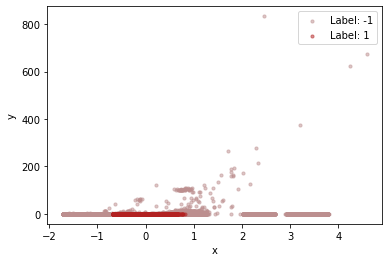

In [267]:
%%time
print('=========== OCSVM FEATURE 1 ===========')
print('=======>>>OCSVM CLUSTER RESULT')
ocsvm_test_label = best_ocsvm.fit(X_train).predict(X_test)
# print results
clustering_print_results(df_test, ocsvm_test_label, selected_features, X_test, True, True )

=======>>>IFOREST CLUSTER RESULT

Exporting LABEL...
Number of clusters: 2
\Label -1: 1033881 data points
\Label 1: 19964 data points

DONE.
--------------------------------------
Wall time: 40.2 s


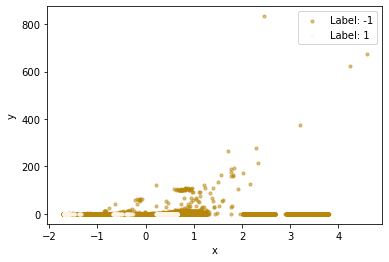

In [266]:
%%time
print('=========== IFOREST FEATURE 1 ===========')
print('=======>>>IFOREST CLUSTER RESULT')
iforest_test_label = best_iforest.fit(X_train).predict(X_test)
# print results
clustering_print_results(df_test, iforest_test_label, selected_features, X_test, True, True )

In [272]:
sort_anomalies    =   ['total_packets', 'bytes_bothdir','bytes_onedir', 'duration']
# get anomalies
anomalies_ocsvm_result = get_anomalies(df_test, ocsvm_test_label)
anomalies_ocsvm_result.sort_values(by=sort_anomalies,ascending=False)
save(anomalies_ocsvm_result, "ocsvm_anomalies")

anomalies_iforest_result = get_anomalies(df_test, iforest_test_label)
anomalies_iforest_result.sort_values(by=sort_anomalies,ascending=False)
save(anomalies_iforest_result, "ifoest_anomalies")

In [284]:
####################### FEATURE 2 Analysis #######################

In [390]:
ocsvm_best_param

{'kernel': 'rbf', 'gamma': 0.01, 'nu': 0.15}

In [391]:
iforest_best_param

{'max_samples': 'auto', 'contamination': 0.3}

In [109]:
X_train = get_pc(X_train_ori, 10)
X_val = get_pc(X_val_ori,10)

PCA.explained variance_ratio_ : 0.9469287695925639
PCA.explained variance_ratio_ : 0.9115256759324034


In [101]:
best_ocsvm = svm.OneClassSVM(**ocsvm_best_param)   
ocsvm_label = best_ocsvm.fit(X_train).predict(X_val)

In [110]:
best_iforest = IsolationForest(**iforest_best_param)
iforest_label = best_iforest.fit(X_train).predict(X_val)

In [111]:
y_pred_ocsvm = ocsvm_label 
y_pred_iforest = iforest_label 
print('Validation data: ')
print('OCSVM: =============')
print_stats(y_pred_ocsvm) 
print()
print('IFOREST: ============')
print_stats(y_pred_iforest)

Validation data: 
OCSVM: =============
Total:  47003
Normal:  5528
Anomaly:  41475

IFOREST: ============
Total:  47003
Normal:  1828
Anomaly:  45175


In [106]:
print('=========== OCSVM: FEATURE 2 ===========')
print(classification_report(y_true, y_pred_ocsvm))
(TP, FP, TN, FN) = perf_measure(y_true, y_pred_ocsvm)
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print('| TP: ', TP, '| FP: ', FP, '| TN: ', TN, '| FN: ', FN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('TPR - FPR : ', TPR - FPR )

=========== OCSVM: FEATURE 2 ===========
              precision    recall  f1-score   support

          -1       0.97      0.91      0.94     44057
           1       0.29      0.55      0.38      2946

    accuracy                           0.89     47003
   macro avg       0.63      0.73      0.66     47003
weighted avg       0.93      0.89      0.90     47003

| TP:  40153 | FP:  1322 | TN:  1624 | FN:  3904
TPR:  0.9113875207118052
FPR:  0.4487440597420231
TPR - FPR :  0.4626434609697821


In [112]:
print('=========== IFOREST FEATURE 2 ===========')
print(classification_report(y_true, y_pred_iforest))
(TP, FP, TN, FN) = perf_measure(y_true, y_pred_iforest)
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print('| TP: ', TP, '| FP: ', FP, '| TN: ', TN, '| FN: ', FN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('TPR - FPR : ', TPR - FPR)

=========== IFOREST FEATURE 2 ===========
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95     44057
           1       0.09      0.06      0.07      2946

    accuracy                           0.91     47003
   macro avg       0.51      0.51      0.51     47003
weighted avg       0.89      0.91      0.90     47003

| TP:  42395 | FP:  2780 | TN:  166 | FN:  1662
TPR:  0.9622761422702408
FPR:  0.9436524100475221
TPR - FPR :  0.018623732222718736


In [114]:
X_test = df_test[selected_features]
X_test = get_pc(X_test, 10)

PCA.explained variance_ratio_ : 0.9200865845868786


In [488]:
len(iforest_test_label)

870431

=========== OCSVM FEATURE 2 ===========
=======>>>OCSVM CLUSTER RESULT

Exporting LABEL...
Number of clusters: 2
\Label -1: 825584 data points
\Label 1: 228261 data points

DONE.
--------------------------------------
Wall time: 46.1 s


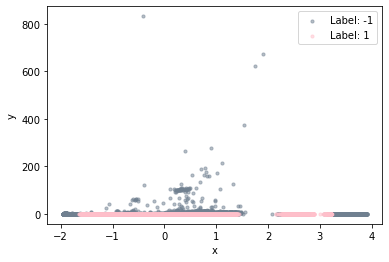

In [115]:
%%time
print('=========== OCSVM FEATURE 2 ===========')
print('=======>>>OCSVM CLUSTER RESULT')
ocsvm_test_label = best_ocsvm.fit(X_train).predict(X_test)
# print results
clustering_print_results(df_test, ocsvm_test_label, selected_features, X_test, True, True )

=========== IFOREST FEATURE 2 ===========
=======>>>IFOREST CLUSTER RESULT

Exporting LABEL...
Number of clusters: 2
\Label -1: 978155 data points
\Label 1: 75690 data points

DONE.
--------------------------------------
Wall time: 37.7 s


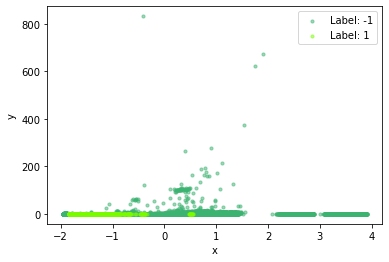

In [116]:
%%time
print('=========== IFOREST FEATURE 2 ===========')
print('=======>>>IFOREST CLUSTER RESULT')
iforest_test_label = best_iforest.fit(X_train).predict(X_test)
# print results
clustering_print_results(df_test, iforest_test_label, selected_features, X_test, True, True )

,timestamp,duration,protocol,src_ip,src_port,direction,dst_ip,dst_port,state,src_type,...,dst_port3,dst_port4,dst_port5,dst_port6,dst_port7,dst_port8,dst_port9,label,x,y
0,2012/12/01 03:36:40.878146,13.342922,tcp,138.11.74.16,6667,<?>,201.30.94.155,1027,PA_PA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.877140,0.540756
1,2012/12/01 03:51:49.918983,11.884443,tcp,138.11.74.16,6667,<?>,201.30.94.155,1027,PA_PA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.849994,0.481309
2,2012/12/01 04:07:21.899558,12.332861,tcp,138.11.74.16,6667,<?>,201.30.94.155,1027,PA_PA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.869314,0.499861
3,2012/12/01 04:38:46.872983,12.834812,tcp,138.11.74.16,6667,<?>,201.30.94.155,1027,PA_PA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.867158,0.522169
4,2012/12/01 04:53:55.866280,12.204415,tcp,138.11.74.16,6667,<?>,201.30.94.155,1027,PA_PA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.861056,0.494133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053840,2012/12/10 23:24:28.388451,-0.188116,tcp,228.91.109.140,6059,->,135.31.242.15,443,S_RA,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1,-1.813706,-0.021952
1053841,2012/12/10 23:24:29.509241,-0.158789,tcp,157.51.106.143,1864,->,162.58.154.76,22,S_,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.799352,-0.020764
1053842,2012/12/10 23:24:30.040003,-0.162865,tcp,157.51.106.143,1865,->,140.18.193.101,22,S_,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.758258,-0.019321
1053843,2012/12/10 23:24:30.892397,-0.188522,tcp,228.91.109.140,6060,->,135.31.242.15,443,S_RA,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1,-1.822083,-0.022361


In [120]:
sort_anomalies    =   ['total_packets', 'bytes_bothdir','bytes_onedir', 'duration']
# get anomalies
anomalies_ocsvm_result = get_anomalies(df_test, ocsvm_test_label)
anomalies_ocsvm_result.sort_values(by=sort_anomalies,ascending=False)
save(anomalies_ocsvm_result, "ocsvm_f2_anomalies")

anomalies_iforest_result = get_anomalies(df_test, iforest_test_label)
anomalies_iforest_result.sort_values(by=sort_anomalies,ascending=False)
save(anomalies_iforest_result, "ifoest_f2_anomalies")

In [285]:
####################### FEATURE 3 Analysis #######################

In [438]:
ocsvm_best_param

{'kernel': 'rbf', 'gamma': 0.15, 'nu': 0.2}

In [439]:
iforest_best_param

{'max_samples': 0.2, 'contamination': 0.1}

In [161]:
X_train = get_pc(X_train_ori, 5)
X_val = get_pc(X_val_ori, 5)

PCA.explained variance_ratio_ : 0.8505886924542188
PCA.explained variance_ratio_ : 0.8495007721308345


In [162]:
best_ocsvm = svm.OneClassSVM(**ocsvm_best_param)   
ocsvm_label = best_ocsvm.fit(X_train).predict(X_val)

In [163]:
best_iforest = IsolationForest(**iforest_best_param)
iforest_label = best_iforest.fit(X_train).predict(X_val)

In [164]:
y_pred_ocsvm = ocsvm_label 
y_pred_iforest = iforest_label 
print('Validation data: ')
print('OCSVM: =============')
print_stats(y_pred_ocsvm) 
print()
print('IFOREST: ============')
print_stats(y_pred_iforest)

Validation data: 
OCSVM: =============
Total:  41073
Normal:  4586
Anomaly:  36487

IFOREST: ============
Total:  41073
Normal:  1230
Anomaly:  39843


In [165]:
print('=========== OCSVM: FEATURE 3 ===========')
print(classification_report(y_true, y_pred_ocsvm))
(TP, FP, TN, FN) = perf_measure(y_true, y_pred_ocsvm)
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print('| TP: ', TP, '| FP: ', FP, '| TN: ', TN, '| FN: ', FN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('TPR - FPR : ', TPR - FPR )

=========== OCSVM: FEATURE 3 ===========
              precision    recall  f1-score   support

          -1       0.97      0.92      0.95     38271
           1       0.36      0.59      0.45      2802

    accuracy                           0.90     41073
   macro avg       0.66      0.76      0.70     41073
weighted avg       0.93      0.90      0.91     41073

| TP:  35331 | FP:  1156 | TN:  1646 | FN:  2940
TPR:  0.923179430900682
FPR:  0.4125624553890079
TPR - FPR :  0.5106169755116741


In [166]:
print('=========== IFOREST FEATURE 3 ===========')
print(classification_report(y_true, y_pred_iforest))
(TP, FP, TN, FN) = perf_measure(y_true, y_pred_iforest)
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print('| TP: ', TP, '| FP: ', FP, '| TN: ', TN, '| FN: ', FN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('TPR - FPR : ', TPR - FPR)

=========== IFOREST FEATURE 3 ===========
              precision    recall  f1-score   support

          -1       0.94      0.98      0.96     38271
           1       0.23      0.10      0.14      2802

    accuracy                           0.92     41073
   macro avg       0.58      0.54      0.55     41073
weighted avg       0.89      0.92      0.90     41073

| TP:  37327 | FP:  2516 | TN:  286 | FN:  944
TPR:  0.9753338036633482
FPR:  0.8979300499643112
TPR - FPR :  0.07740375369903696


In [168]:
X_test = df_test[selected_features]
X_test = get_pc(X_test, 5)

PCA.explained variance_ratio_ : 0.8692339371946369


=========== OCSVM FEATURE 3 ===========
=======>>>OCSVM CLUSTER RESULT

Exporting LABEL...
Number of clusters: 2
\Label -1: 761112 data points
\Label 1: 109319 data points

DONE.
--------------------------------------
Wall time: 1min 55s


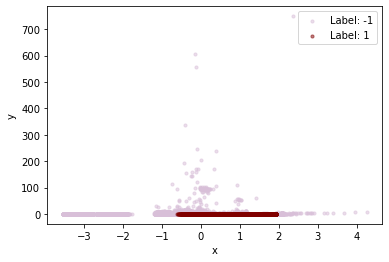

In [169]:
%%time
print('=========== OCSVM FEATURE 3 ===========')
print('=======>>>OCSVM CLUSTER RESULT')
ocsvm_test_label = best_ocsvm.fit(X_train).predict(X_test)
# print results
clustering_print_results(df_test, ocsvm_test_label, selected_features, X_test, True, True )

=========== IFOREST FEATURE 3 ===========
=======>>>IFOREST CLUSTER RESULT

Exporting LABEL...
Number of clusters: 2
\Label -1: 870424 data points
\Label 1: 7 data points

DONE.
--------------------------------------
Wall time: 29.7 s


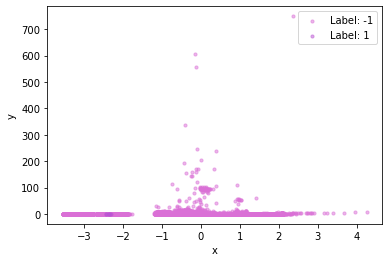

In [173]:
%%time
print('=========== IFOREST FEATURE 3 ===========')
print('=======>>>IFOREST CLUSTER RESULT')
iforest_test_label = best_iforest.fit(X_train).predict(X_test)
# print results
clustering_print_results(df_test, iforest_test_label, selected_features, X_test, True, True )

In [ ]:
## SECTION 8: Save anomalies to csv

In [190]:
len(df_test)

870431

In [191]:
#Already exported
#sort_anomalies    =   ['total_packets', 'bytes_bothdir','bytes_onedir', 'duration']
# get anomalies
#anomalies_ocsvm_result = get_anomalies(df_test, ocsvm_test_label)
#anomalies_ocsvm_result.sort_values(by=sort_anomalies,ascending=False)
#save(anomalies_ocsvm_result, "ocsvm_f3_anomalies")

In [187]:
anomalies_iforest_result = get_anomalies(df_test, iforest_test_label)
anomalies_iforest_result.sort_values(by=sort_anomalies,ascending=False)
save(anomalies_iforest_result, "ifoest_f3_anomalies")

In [ ]:
## TASK2 GENERATING ADVERSARIAL SAMPLES =>>> Moved to another separate notebook file

In [674]:
from sklearn.linear_model import LogisticRegression

headers = ['timestamp','duration','protocol', 'src_ip', 'src_port', 'direction', 'dst_ip' , 'dst_port'
           ,'state', 'src_type', 'dst_type' , 'total_packets', 'bytes_bothdir', 'bytes_onedir', 'label']

df_train_original = pd.read_csv("training_data_with_labels.csv", names=headers, header=None).sample(frac=0.05, replace=False, random_state=42).fillna(-1)
#df_val_notsampled = pd.read_csv("A2_2/valid_data_with_labels.csv", names=val_headers, header=None).fillna(-1)
df_test_original = pd.read_csv("test_data_with_labels.csv", names=headers, header=None).fillna(-1)

print('DONE')

DONE


In [675]:
print(len(df_train_original))

98908


In [676]:
train_headers = ['timestamp','duration','protocol', 'src_ip', 'src_port', 'direction', 'dst_ip' , 'dst_port'
           ,'state', 'src_type', 'dst_type' , 'total_packets', 'bytes_bothdir', 'bytes_onedir']

df_train_original['label']= df_train_original['label'].apply(str)
df_train_original.loc[df_train_original['label'].str.contains("From-Botnet"), 'label'] = -1
df_train_original.loc[df_train_original['label'].str.contains("From-Botnet")== False, 'label'] = 1
df_train_original.label = df_train_original.label.astype(int)

df_test_original['label']= df_test_original['label'].apply(str)
df_test_original.loc[df_test_original['label'].str.contains("From-Botnet"), 'label'] = -1
df_test_original.loc[df_test_original['label'].str.contains("From-Botnet")== False, 'label'] = 1
df_test_original.label = df_test_original.label.astype(int)


In [678]:
X_train = df_train_original
X_test = df_test_original
print(len(X_train))
print(len(X_test))

98908
574383


In [679]:
print(len(X_train[X_train['label']==1]))
print(len(X_train[X_train['label']==-1]))

53954
44954


In [681]:
%%time
print('Generatingi features... ')
X_train = get_feature3('val', X_train) 
print('train len: ', len(X_train))
Y = X_train['label']

feature3 = ['bytes_bothdir', 'bytes_onedir', 'total_packets', 'duration', 
             'pps', 'bps_onedir', 'bpp_onedir', 'bps_bothdir', 'bpp_bothdir', 
             'cnt_timed_src', 'cnt_timed_dst', 'cnt_timed_srcdst']

selected_features = feature3
columns_to_scale = feature3

X_train[columns_to_scale] = apply_scaler(X_train)
X_train = X_train[selected_features]
X = get_pc(X_train, 3)
Y = np.array(Y)
print('DONE')

Generatingi features... 
val DONE
train len:  70584
PCA.explained variance_ratio_ : 0.6232298575880069
DONE
Wall time: 32.6 s


In [684]:
class logistic_regression2(object):
    def fit(self, X, Y, learning_rate=0.0000003, epoch=1000):
        X = np.array(X, dtype="float32")
        Y = np.array(Y, dtype="float32")

        N, D = X.shape
        Y = Y.reshape(N, 1)

        dlt = np.zeros([N, 1], dtype="float32")
        dW = np.zeros([1, D], dtype="float32")
        db = 0
        self.weight = np.zeros([D, 1], dtype="float32")
        self.beta = 0

        c = []

        for n in range(epoch):
            dlt = self.predict(X).T - Y
            dW = np.matmul(dlt.T, X).T
            db = dlt.sum() / N

            self.weight -= learning_rate * dW
            self.beta -= learning_rate * db
            if n % 200 == 0:
                c_new = cost(self.predict(X).T, Y)
                c.append(c_new)
                err = error_rate(self.predict_class(X).T, Y)
                print("epoch:", n, "cost:", c_new, "error rate:", err)

    def predict(self, X):
        z = np.matmul(self.weight.T, X.T) + self.beta
        return 1 / (1 + np.exp(-z))

    def predict_class(self, X):
        predictclass = self.predict(X)
        return (predictclass >= 0.5) * 1
                
    def predict(self, X):
        z = np.matmul(self.weight.T, X.T) + self.beta
        return 1 / (1 + np.exp(-z))

    def predict_class(self, X):
        predictclass = self.predict(X)
        return (predictclass >= 0.5) * 1
                
def error_rate(P, Y):
    return np.mean(Y != P)

def adversial_samples(X, Y, model, epsilon=0.00001):
    dlt = model.predict(X).T - Y.reshape(X.shape[0], 1)
    direction = np.sign(np.matmul(dlt, model.weight.T))
    return X + epsilon * direction, Y

def cost(Y_hat, Y):
    Y_hat = Y_hat.flatten()
    Y = Y.flatten()
    cost1 = 0
    elp = 0.0000000000000000000000000000000000000000000001
    for i in range(len(Y)):
        cost1 -= Y[i] * np.log(Y_hat[i] + elp) + (1 - Y[i]) * np.log(1 - Y_hat[i] + elp)
    return cost1



model = logistic_regression2()
model.fit(X, Y, learning_rate=0.0005,  epoch=1000) #20000

#model = LogisticRegression()
#model.fit(X, Y)

C:\Users\kebin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


epoch: 0 cost: 265939.7362045402 error rate: 0.34964014507537117
epoch: 200 cost: 3463993.5325673562 error rate: 0.36794457667460045
epoch: 400 cost: 3486488.2836368647 error rate: 0.36795874419131813
epoch: 600 cost: 3496335.754784658 error rate: 0.36795874419131813
epoch: 800 cost: 3502254.413517331 error rate: 0.36795874419131813


C:\Users\kebin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


Error Rate without adversarial examples: 0.3679870792247535
Error Rate with adversarial examples, epsilon = 0.2: 0.3697296837810269
Error Rate with adversarial examples, epsilon = 0.5: 0.3697296837810269


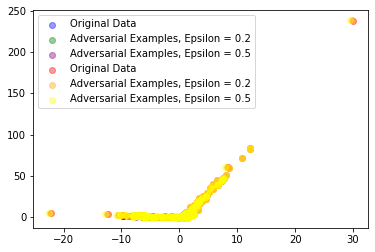

In [686]:
print('Error Rate without adversarial examples:', error_rate(model.predict_class(X).T, Y.reshape(X.shape[0], 1)))

Xadv, Y = adversial_samples(X, Y, model, epsilon=0.2)
print('Error Rate with adversarial examples, epsilon = 0.2:', error_rate(model.predict(Xadv).T, Y.reshape(Xadv.shape[0], 1)))
Xadv2, Y = adversial_samples(X, Y, model, epsilon=0.5)
print('Error Rate with adversarial examples, epsilon = 0.5:', error_rate(model.predict(Xadv2).T, Y.reshape(Xadv2.shape[0], 1)))

plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')
plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()

C:\Users\kebin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


Error Rate without adversarial examples: 0.3697296837810269
Error Rate with adversarial examples, epsilon = 0.2: 0.3697296837810269
Error Rate with adversarial examples, epsilon = 0.5: 0.3697296837810269


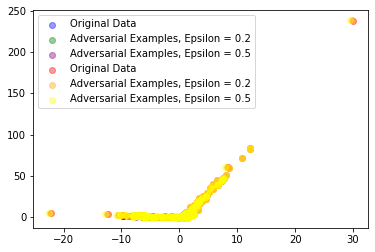

In [664]:
print('Error Rate without adversarial examples:', error_rate(model.predict(X).T, Y.reshape(X.shape[0], 1)))
Xadv, Y = adversial_samples(X, Y, model, epsilon=0.2)
print('Error Rate with adversarial examples, epsilon = 0.2:', error_rate(model.predict(Xadv).T, Y.reshape(Xadv.shape[0], 1)))
Xadv2, Y = adversial_samples(X, Y, model, epsilon=0.5)
print('Error Rate with adversarial examples, epsilon = 0.5:', error_rate(model.predict(Xadv2).T, Y.reshape(Xadv2.shape[0], 1)))

plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')
plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()